In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
IMG_SIZE = 64
NUM_CLASSES = 7
BASE_DIR = "."
TRAINVAL_FILE = "trainval.txt"
EPOCHS = 50
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "dc_exp_2.pth"

In [3]:
class DefectDataset(Dataset):
    def __init__(self, base_path, file_list_path, img_size):
        with open(file_list_path, "r") as f:
            lines = f.readlines()

        self.images, self.masks = [], []

        for line in lines:
            img_path_rel, ann_path_rel = line.strip().split()
            img_path_full = os.path.join(base_path, img_path_rel.replace(".jpg", "_test.jpg"))
            ann_path_full = os.path.join(base_path, ann_path_rel)

            img = Image.open(img_path_full).convert("RGB")
            orig_size = img.size
            img = img.resize((img_size, img_size), Image.Resampling.LANCZOS)
            self.images.append(np.array(img, dtype=np.float32) / 255.0)

            mask = np.zeros((img_size, img_size), dtype=np.int64)
            scale_x, scale_y = img_size / orig_size[0], img_size / orig_size[1]

            with open(ann_path_full, "r") as f_ann:
                for l in f_ann:
                    parts = l.strip().split()
                    if len(parts) < 5:
                        continue
                    x1, y1, x2, y2, class_id = map(int, parts)
                    nx1, ny1 = max(0, int(x1 * scale_x)), max(0, int(y1 * scale_y))
                    nx2, ny2 = min(img_size - 1, int(x2 * scale_x)), min(img_size - 1, int(y2 * scale_y))
                    if ny1 < ny2 and nx1 < nx2:
                        mask[ny1:ny2, nx1:nx2] = class_id
            self.masks.append(mask)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx].transpose(2, 0, 1), dtype=torch.float32)
        mask = torch.tensor(self.masks[idx], dtype=torch.long)
        return img, mask

In [4]:
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class AttentionUNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Encoder Path (4 levels)
        self.enc1 = self.conv_block(3, 64, 0.2)
        self.enc2 = self.conv_block(64, 128, 0.2)
        self.enc3 = self.conv_block(128, 256, 0.3)
        self.enc4 = self.conv_block(256, 512, 0.3)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024, 0.4)

        # Decoder Path
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.att1 = AttentionGate(F_g=512, F_l=512, F_int=256)
        self.dec1 = self.conv_block(1024, 512, 0.3)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.att2 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.dec2 = self.conv_block(512, 256, 0.3)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.att3 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.dec3 = self.conv_block(256, 128, 0.2)

        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.att4 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.dec4 = self.conv_block(128, 64, 0.2)

        # Final output
        self.out_conv = nn.Conv2d(64, num_classes, 1)
        self.pool = nn.MaxPool2d(2)

    def conv_block(self, in_c, out_c, drop):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Dropout2d(drop),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        p1 = self.pool(c1)

        c2 = self.enc2(p1)
        p2 = self.pool(c2)

        c3 = self.enc3(p2)
        p3 = self.pool(c3)

        c4 = self.enc4(p3)
        p4 = self.pool(c4)

        # Bottleneck
        b = self.bottleneck(p4)

        # Decoder with Attention Gates
        u1 = self.up1(b)
        a1 = self.att1(g=u1, x=c4)
        u1 = torch.cat([a1, u1], dim=1)
        d1 = self.dec1(u1)

        u2 = self.up2(d1)
        a2 = self.att2(g=u2, x=c3)
        u2 = torch.cat([a2, u2], dim=1)
        d2 = self.dec2(u2)

        u3 = self.up3(d2)
        a3 = self.att3(g=u3, x=c2)
        u3 = torch.cat([a3, u3], dim=1)
        d3 = self.dec3(u3)

        u4 = self.up4(d3)
        a4 = self.att4(g=u4, x=c1)
        u4 = torch.cat([a4, u4], dim=1)
        d4 = self.dec4(u4)

        return self.out_conv(d4)

In [5]:
def pixel_accuracy(preds, masks):
    return (preds == masks).sum().item() / masks.numel()


def display_results(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.legend()
    plt.title("Pixel Accuracy")

    plt.show()


def display_prediction(image, true_mask, pred_mask):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.transpose(1, 2, 0))
    plt.title("Input Image")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask)
    plt.title("True Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask)
    plt.title("Predicted Mask")

    plt.show()

Epoch [1/50] Train Loss: 1.2119, Train Acc: 0.8368 | Val Loss: 1.0644, Val Acc: 0.9754


Epoch [2/50] Train Loss: 0.5604, Train Acc: 0.9751 | Val Loss: 0.5211, Val Acc: 0.9751


Epoch [3/50] Train Loss: 0.2989, Train Acc: 0.9758 | Val Loss: 0.2638, Val Acc: 0.9757


Epoch [4/50] Train Loss: 0.2058, Train Acc: 0.9760 | Val Loss: 0.1965, Val Acc: 0.9757


Epoch [5/50] Train Loss: 0.1730, Train Acc: 0.9760 | Val Loss: 0.1658, Val Acc: 0.9757


Epoch [6/50] Train Loss: 0.1563, Train Acc: 0.9760 | Val Loss: 0.1504, Val Acc: 0.9757


Epoch [7/50] Train Loss: 0.1444, Train Acc: 0.9760 | Val Loss: 0.1416, Val Acc: 0.9758


Epoch [8/50] Train Loss: 0.1339, Train Acc: 0.9760 | Val Loss: 0.1386, Val Acc: 0.9758


Epoch [9/50] Train Loss: 0.1245, Train Acc: 0.9763 | Val Loss: 0.1476, Val Acc: 0.9763


Epoch [10/50] Train Loss: 0.1175, Train Acc: 0.9766 | Val Loss: 0.1506, Val Acc: 0.9767


Epoch [11/50] Train Loss: 0.1106, Train Acc: 0.9769 | Val Loss: 0.1084, Val Acc: 0.9770


Epoch [12/50] Train Loss: 0.1051, Train Acc: 0.9773 | Val Loss: 0.1064, Val Acc: 0.9774


Epoch [13/50] Train Loss: 0.0997, Train Acc: 0.9776 | Val Loss: 0.0973, Val Acc: 0.9784


Epoch [14/50] Train Loss: 0.0956, Train Acc: 0.9781 | Val Loss: 0.0947, Val Acc: 0.9788


Epoch [15/50] Train Loss: 0.0907, Train Acc: 0.9788 | Val Loss: 0.0890, Val Acc: 0.9793


Epoch [16/50] Train Loss: 0.0878, Train Acc: 0.9790 | Val Loss: 0.0854, Val Acc: 0.9796


Epoch [17/50] Train Loss: 0.0853, Train Acc: 0.9792 | Val Loss: 0.0845, Val Acc: 0.9798


Epoch [18/50] Train Loss: 0.0829, Train Acc: 0.9796 | Val Loss: 0.0794, Val Acc: 0.9803


Epoch [19/50] Train Loss: 0.0792, Train Acc: 0.9801 | Val Loss: 0.0799, Val Acc: 0.9802


Epoch [20/50] Train Loss: 0.0771, Train Acc: 0.9804 | Val Loss: 0.0756, Val Acc: 0.9810


Epoch [21/50] Train Loss: 0.0748, Train Acc: 0.9808 | Val Loss: 0.0741, Val Acc: 0.9813


Epoch [22/50] Train Loss: 0.0724, Train Acc: 0.9813 | Val Loss: 0.0887, Val Acc: 0.9812


Epoch [23/50] Train Loss: 0.0702, Train Acc: 0.9817 | Val Loss: 0.0720, Val Acc: 0.9820


Epoch [24/50] Train Loss: 0.0689, Train Acc: 0.9820 | Val Loss: 0.0721, Val Acc: 0.9824


Epoch [25/50] Train Loss: 0.0668, Train Acc: 0.9825 | Val Loss: 0.0664, Val Acc: 0.9829


Epoch [26/50] Train Loss: 0.0657, Train Acc: 0.9826 | Val Loss: 0.0679, Val Acc: 0.9823


Epoch [27/50] Train Loss: 0.0646, Train Acc: 0.9826 | Val Loss: 0.0649, Val Acc: 0.9833


Epoch [28/50] Train Loss: 0.0632, Train Acc: 0.9833 | Val Loss: 0.0674, Val Acc: 0.9832


Epoch [29/50] Train Loss: 0.0598, Train Acc: 0.9839 | Val Loss: 0.0618, Val Acc: 0.9842


Epoch [30/50] Train Loss: 0.0582, Train Acc: 0.9842 | Val Loss: 0.0643, Val Acc: 0.9837


Epoch [31/50] Train Loss: 0.0565, Train Acc: 0.9846 | Val Loss: 0.0627, Val Acc: 0.9841


Epoch [32/50] Train Loss: 0.0546, Train Acc: 0.9850 | Val Loss: 0.0613, Val Acc: 0.9846


Epoch [33/50] Train Loss: 0.0518, Train Acc: 0.9857 | Val Loss: 0.0570, Val Acc: 0.9854


Epoch [34/50] Train Loss: 0.0521, Train Acc: 0.9855 | Val Loss: 0.0603, Val Acc: 0.9843


Epoch [35/50] Train Loss: 0.0510, Train Acc: 0.9858 | Val Loss: 0.0580, Val Acc: 0.9850


Epoch [36/50] Train Loss: 0.0485, Train Acc: 0.9864 | Val Loss: 0.0545, Val Acc: 0.9856


Epoch [37/50] Train Loss: 0.0480, Train Acc: 0.9865 | Val Loss: 0.0544, Val Acc: 0.9854


Epoch [38/50] Train Loss: 0.0467, Train Acc: 0.9868 | Val Loss: 0.0539, Val Acc: 0.9862


Epoch [39/50] Train Loss: 0.0440, Train Acc: 0.9873 | Val Loss: 0.0577, Val Acc: 0.9853


Epoch [40/50] Train Loss: 0.0428, Train Acc: 0.9877 | Val Loss: 0.0525, Val Acc: 0.9858


Epoch [41/50] Train Loss: 0.0420, Train Acc: 0.9878 | Val Loss: 0.0524, Val Acc: 0.9863


Epoch [42/50] Train Loss: 0.0413, Train Acc: 0.9880 | Val Loss: 0.0517, Val Acc: 0.9862


Epoch [43/50] Train Loss: 0.0401, Train Acc: 0.9883 | Val Loss: 0.0529, Val Acc: 0.9864


Epoch [44/50] Train Loss: 0.0389, Train Acc: 0.9885 | Val Loss: 0.0522, Val Acc: 0.9866


Epoch [45/50] Train Loss: 0.0372, Train Acc: 0.9890 | Val Loss: 0.0501, Val Acc: 0.9871


Epoch [46/50] Train Loss: 0.0371, Train Acc: 0.9889 | Val Loss: 0.0507, Val Acc: 0.9869


Epoch [47/50] Train Loss: 0.0351, Train Acc: 0.9895 | Val Loss: 0.0527, Val Acc: 0.9867


Epoch [48/50] Train Loss: 0.0353, Train Acc: 0.9894 | Val Loss: 0.0499, Val Acc: 0.9870


Epoch [49/50] Train Loss: 0.0338, Train Acc: 0.9897 | Val Loss: 0.0540, Val Acc: 0.9867


Epoch [50/50] Train Loss: 0.0325, Train Acc: 0.9901 | Val Loss: 0.0506, Val Acc: 0.9872
Final model saved to dc_exp_2.pth


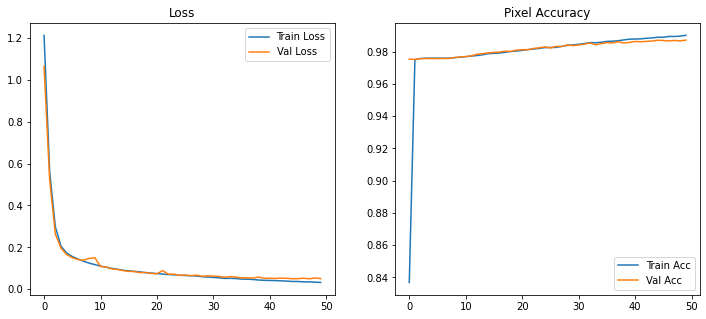

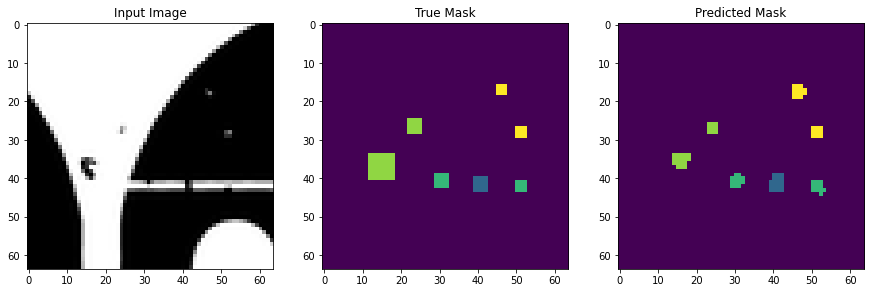

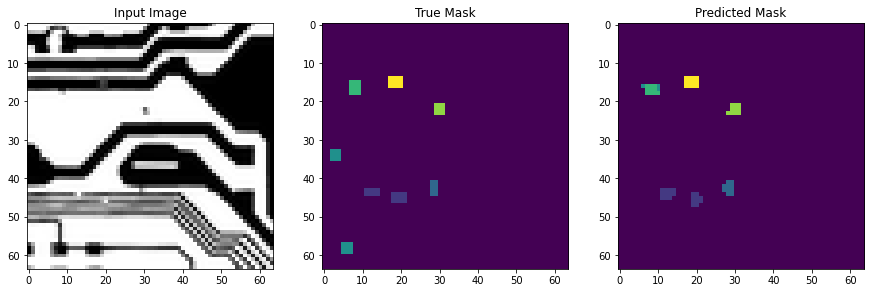

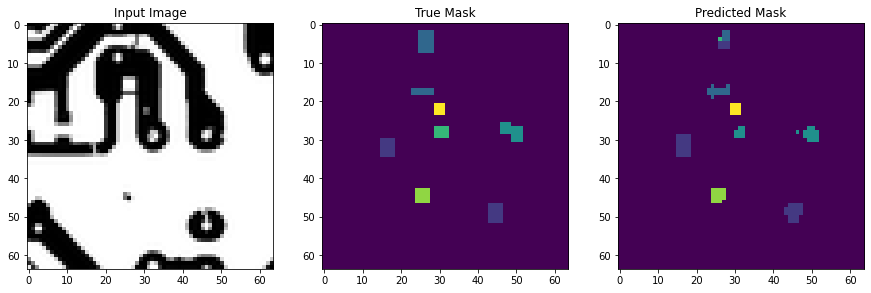

In [6]:
if __name__ == "__main__":
    dataset = DefectDataset(BASE_DIR, TRAINVAL_FILE, IMG_SIZE)
    n_val = int(0.2 * len(dataset))
    n_train = len(dataset) - n_val

    train_set, val_set = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

    model = AttentionUNet(NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(EPOCHS):
        model.train()
        running_loss, running_acc = 0, 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

        for imgs, masks in loop:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            acc = pixel_accuracy(preds, masks)
            running_acc += acc

            loop.set_postfix(loss=loss.item(), acc=acc)

        train_losses.append(running_loss / len(train_loader))
        train_accs.append(running_acc / len(train_loader))

        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, masks)

                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_acc += pixel_accuracy(preds, masks)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_acc / len(val_loader))

        print(
            f"Epoch [{epoch+1}/{EPOCHS}] "
            f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f} | "
            f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}"
        )

    torch.save(model.state_dict(), MODEL_PATH)
    print(f"Final model saved to {MODEL_PATH}")
    
    display_results(train_losses, val_losses, train_accs, val_accs)

    sample_imgs, sample_masks = next(iter(val_loader))
    sample_imgs = sample_imgs.to(DEVICE)
    with torch.no_grad():
        preds = torch.argmax(model(sample_imgs), dim=1).cpu().numpy()

    for i in range(min(3, len(sample_imgs))):
        display_prediction(sample_imgs[i].cpu().numpy(), sample_masks[i].numpy(), preds[i])